In [1]:
!rm -rf /kaggle/working/multimodal-eq-sizing
!git clone https://github.com/brianrp09232000/multimodal-eq-sizing.git /kaggle/working/multimodal-eq-sizing
!pip install -r /kaggle/working/multimodal-eq-sizing/requirements.txt

Cloning into '/kaggle/working/multimodal-eq-sizing'...
remote: Enumerating objects: 890, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 890 (delta 153), reused 110 (delta 101), pack-reused 675 (from 3)
Receiving objects: 100% (890/890), 1.36 MiB | 22.44 MiB/s, done.
Resolving deltas: 100% (545/545), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.0 MB/s eta 0:00:00:00

# Modules

In [2]:
import sys
import pathlib

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import os

In [3]:
start_time = datetime.now()

In [4]:
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [5]:
# Uses the current directory where the notebook is running
repo_root = pathlib.Path("multimodal-eq-sizing")
sys.path.append(str(repo_root.resolve())) # .resolve() gets the full absolute path locally

In [6]:
from src.models import price_mlp 
from src.models.price_mlp import rmse, summarize_price_model_diagnostics
from src.models.price_mlp import select_feature_columns, scale_features, create_sliding_windows_single_stock
from src.models.price_mlp import split_single_stock, build_panel_dataset
from src.utils.cv import make_yearly_walkforward_splits, generate_yearly_oof, _train_predict_year

2025-12-09 23:51:37.253607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765324297.547546      81 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765324297.627367      81 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Read Data

In [7]:
df = pd.read_pickle("/kaggle/input/nasdaq-news/proc_multimodal_eq_sizing_dataset.pkl")

# Configurations

In [8]:
################# Configurations #######################
DATA_PATH  = "/kaggle/working/final_dataset.csv"   
DATE_COL   = "Date"                    
TICKER_COL = "ticker"                  
TARGET_COL = 'next_day_excess_return'             

FEATURE_COLS = [
 'mom_rank',
 'spy_r1',
 'o2c_return',
 'excess_return',
 'VIX_Close',
 'VIX_z',
 'spread_z',
 'dollar_volume',
 'adv_dollar',
    'mom_12_1',
 'next_day_excess_return' ]

WINDOW_SIZE = 30        
TEST_RATIO  = 0.20      
VAL_RATIO   = 0.10      

BATCH_SIZE   = 64
EPOCHS       = 30
LEARNING_RATE = 1e-3
DROPOUT_RATE = 0.2
GRU_UNITS    = 128
LSTM_UNITS   = 128
DENSE_UNITS  = 64

# Select Feature Columns

In [9]:
def select_feature_columns(df: pd.DataFrame):
    """
    Decide which features to use：
    - if FEATURE_COLS is not None，use this function；
    - o/w use all numerical cols，excluding Date and ticker
    """
    global FEATURE_COLS

    if FEATURE_COLS is not None:
        missing = [c for c in FEATURE_COLS if c not in df.columns]
        if len(missing) > 0:
            raise ValueError(f"FEATURE_COLS is not in the dataset: {missing}")
    else:
        exclude_cols = {DATE_COL, TICKER_COL}
        FEATURE_COLS = [
            c for c in df.columns
            if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])
        ]
        print("Auto selected FEATURE_COLS:", FEATURE_COLS)

    if TARGET_COL not in FEATURE_COLS:
        raise ValueError(
            f"TARGET_COL='{TARGET_COL}'must included in the FEATURE_COLS，"
        )

    return FEATURE_COLS

In [10]:
feature_cols = select_feature_columns(df) 

# Split Data

In [11]:
def split_data_on_year(df, DATE_COL, train_years, val_years, test_years):

    # split by date
    df_train = df[df[DATE_COL] >= str(train_years[0])+'-01-01']
    df_train = df_train[df_train[DATE_COL] <= str(train_years[1])+'-12-31']
    df_val = df[df[DATE_COL] >= str(val_years[0])+'-01-01']
    df_val = df_val[df_val[DATE_COL] <= str(val_years[1])+'-12-31']
    df_test = df[df[DATE_COL] >= str(test_years[0])+'-01-01']
    df_test = df_test[df_test[DATE_COL] < str(test_years[1])+'-12-31']

    return df_train, df_val, df_test

# create X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
def create_numpy_data_type(df_train, df_val, df_test, feature_cols, TARGET_COL):

    
    y_train = np.array(df_train[TARGET_COL])
    y_val = np.array(df_val[TARGET_COL])#.dropna())
    y_test = np.array(df_test[TARGET_COL])#.dropna())
    
    model_input_cols = feature_cols.copy()
    model_input_cols.remove(TARGET_COL)

    X_train = np.array(df_train[model_input_cols])#.dropna(axis=1))
    X_val = np.array(df_val[model_input_cols])#.dropna(axis=1))
    X_test = np.array(df_test[model_input_cols])#.dropna(axis=1))

    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Normalize Data

In [13]:
def normalize_data(xtrain, xval, xtest):

    xscaler = MinMaxScaler(feature_range=(0, 1))
    xtrain = xscaler.fit_transform(xtrain)
    xval = xscaler.transform(xval)
    xtest = xscaler.transform(xtest)
    return xtrain, xval, xtest, xscaler

# Reshape Data

In [14]:
def reshape_data(xtrain, xval, xtest):

    xtrain = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1)
    xval = xval.reshape(xval.shape[0], xval.shape[1], 1)
    xtest = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)
    
    #print(xtrain.shape, ytrain.shape, xval.shape,yval.shape, xtest.shape,ytest.shape)
    return xtrain, xval, xtest

# Model Function

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam

####################### Build hybrid GRU LSTM model ###################

def build_hybrid_gru_lstm(input_shape):
    """
    input_shape: (WINDOW_SIZE, num_features)

    Input
      → GRU(128, return_sequences=True) + Dropout(0.2)
      → LSTM(128) + Dropout(0.2)
      → Dense(64, relu)
      → Dense(1, linear)
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.GRU(
        GRU_UNITS,
        return_sequences=True,
        dropout=DROPOUT_RATE
    )(inputs)

    x = layers.LSTM(
        LSTM_UNITS,
        dropout=DROPOUT_RATE
    )(x)

    x = layers.Dense(DENSE_UNITS, activation="relu")(x)
    outputs = layers.Dense(1, activation="linear")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="Hybrid_GRU_LSTM")

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )

    return model

In [16]:
df = df.dropna(axis=0, subset=feature_cols, how='any')

# Model

In [17]:
def build_model_for_one_fold(df, feature_cols, TARGET_COL, DATE_COL, split_years):
    
    # split data by year
    train_years, val_years, test_years = split_years[0], split_years[1], split_years[2]
    df_train, df_val, df_test = split_data_on_year(df, DATE_COL, train_years, val_years, test_years)
    
    # create train, val, and test dataset
    X_train, y_train, X_val, y_val, X_test, y_test = create_numpy_data_type(df_train, 
                                                                             df_val, 
                                                                             df_test,
                                                                             feature_cols,
                                                                            TARGET_COL)
    
    # normalize data
    X_train, X_val, X_test, xscaler = normalize_data(X_train, X_val, X_test)
    
    # reshape input data
    X_train, X_val, X_test = reshape_data(X_train, X_val, X_test)
    
    # build model
    model = build_hybrid_gru_lstm(X_train[0].shape)
    
    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, 
                       restore_best_weights=True)
    # Compile
    model.compile(
            optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
            loss="mse",
            metrics=["mae"]
        )
    
    # fit network
    print('Train years      : ', train_years[0], '-', train_years[1])
    print('Valiidation years: ', val_years[0])
    history = model.fit(X_train, y_train, epochs=EPOCHS, 
                        verbose=2, batch_size=64, 
                        validation_data=(X_val, y_val), callbacks=[es])
    
    # predict test data
    y_pred = model.predict(X_test).flatten()
    df_test['y_pred'] = y_pred
    
    # evaluate model
    summarize_price_model_diagnostics(model, history, split_years)
    
    
    y_test = y_test.flatten()
    mse  = mean_squared_error(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    r_mse = price_mlp.rmse(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print()
    print('Test years: ', test_years[0], '-', test_years[1])
    print(f"Test MSE      : {mse:.6f}")
    print(f"Test RMSE     : {r_mse:.6f}")
    print(f"Test MAE      : {mae:.6f}")
    print(f"Test R2 score : {r2}")
    print()
    return df_test, model

In [18]:
def summarize_price_model_diagnostics(model, history, year):
  """plots price model loss and accuracy curves of the train and validation data
  inputs: model - tensorflow model; history - model.fit output
  outputs: none"""
  fig, ax = plt.subplots(1,2, figsize=(20, 10))
  # plot loss
  ax[0].set_title('Loss Curves', fontsize=20)
  ax[0].plot(history.history['loss'], label='train: '+str(year[0][0])+'-'+str(year[0][1]))
  ax[0].plot(history.history['val_loss'], label='validation: '+str(year[1][0]))
  ax[0].set_xlabel('Epochs', fontsize=15)
  ax[0].set_ylabel('Loss', fontsize=15)
  ax[0].legend(fontsize=15)
  # plot mae
  ax[1].set_title('MAE Curves', fontsize=20)
  ax[1].plot(history.history['mae'], label='train: '+str(year[0][0])+'-'+str(year[0][1]))
  ax[1].plot(history.history['val_mae'], label='validation: '+str(year[1][0]))
  ax[1].set_xlabel('Epochs', fontsize=15)
  ax[1].set_ylabel('MAE', fontsize=15)
  ax[1].legend(fontsize=15)

In [19]:
# create list dividing years into train, validation, and test
split_years_list = [[(2011,year),(year+1,year+1),(year+2,year+2)] for year in range(2011,2015)]
split_years_list += [[(2010,2015),(2016,2016),(2017,2018)]]

print('train, validation, test data split')
for i in split_years_list:
    print(i)

train, validation, test data split
[(2011, 2011), (2012, 2012), (2013, 2013)]
[(2011, 2012), (2013, 2013), (2014, 2014)]
[(2011, 2013), (2014, 2014), (2015, 2015)]
[(2011, 2014), (2015, 2015), (2016, 2016)]
[(2010, 2015), (2016, 2016), (2017, 2018)]


2025-12-09 23:52:01.739869: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Train years      :  2011 - 2011
Valiidation years:  2012
Epoch 1/30
656/656 - 33s - 51ms/step - loss: 2.5964e-04 - mae: 0.0109 - val_loss: 2.0400e-04 - val_mae: 0.0095
Epoch 2/30
656/656 - 26s - 40ms/step - loss: 2.5270e-04 - mae: 0.0107 - val_loss: 2.0449e-04 - val_mae: 0.0095
Epoch 3/30
656/656 - 27s - 40ms/step - loss: 2.5259e-04 - mae: 0.0107 - val_loss: 2.0640e-04 - val_mae: 0.0096
Epoch 4/30
656/656 - 31s - 47ms/step - loss: 2.5256e-04 - mae: 0.0107 - val_loss: 2.0418e-04 - val_mae: 0.0095
Epoch 5/30
656/656 - 26s - 40ms/step - loss: 2.5301e-04 - mae: 0.0107 - val_loss: 2.0445e-04 - val_mae: 0.0095
Epoch 6/30
656/656 - 27s - 41ms/step - loss: 2.5285e-04 - mae: 0.0107 - val_loss: 2.0450e-04 - val_mae: 0.0095
Epoch 7/30
656/656 - 26s - 40ms/step - loss: 2.6024e-04 - mae: 0.0109 - val_loss: 2.0695e-04 - val_mae: 0.0096
Epoch 8/30
656/656 - 26s - 40ms/step - loss: 2.5260e-04 - mae: 0.0107 - val_loss: 2.0559e-04 - val_mae: 0.0095
Epoch 9/30
656/656 - 26s - 39ms/step - loss: 2.5260e-04

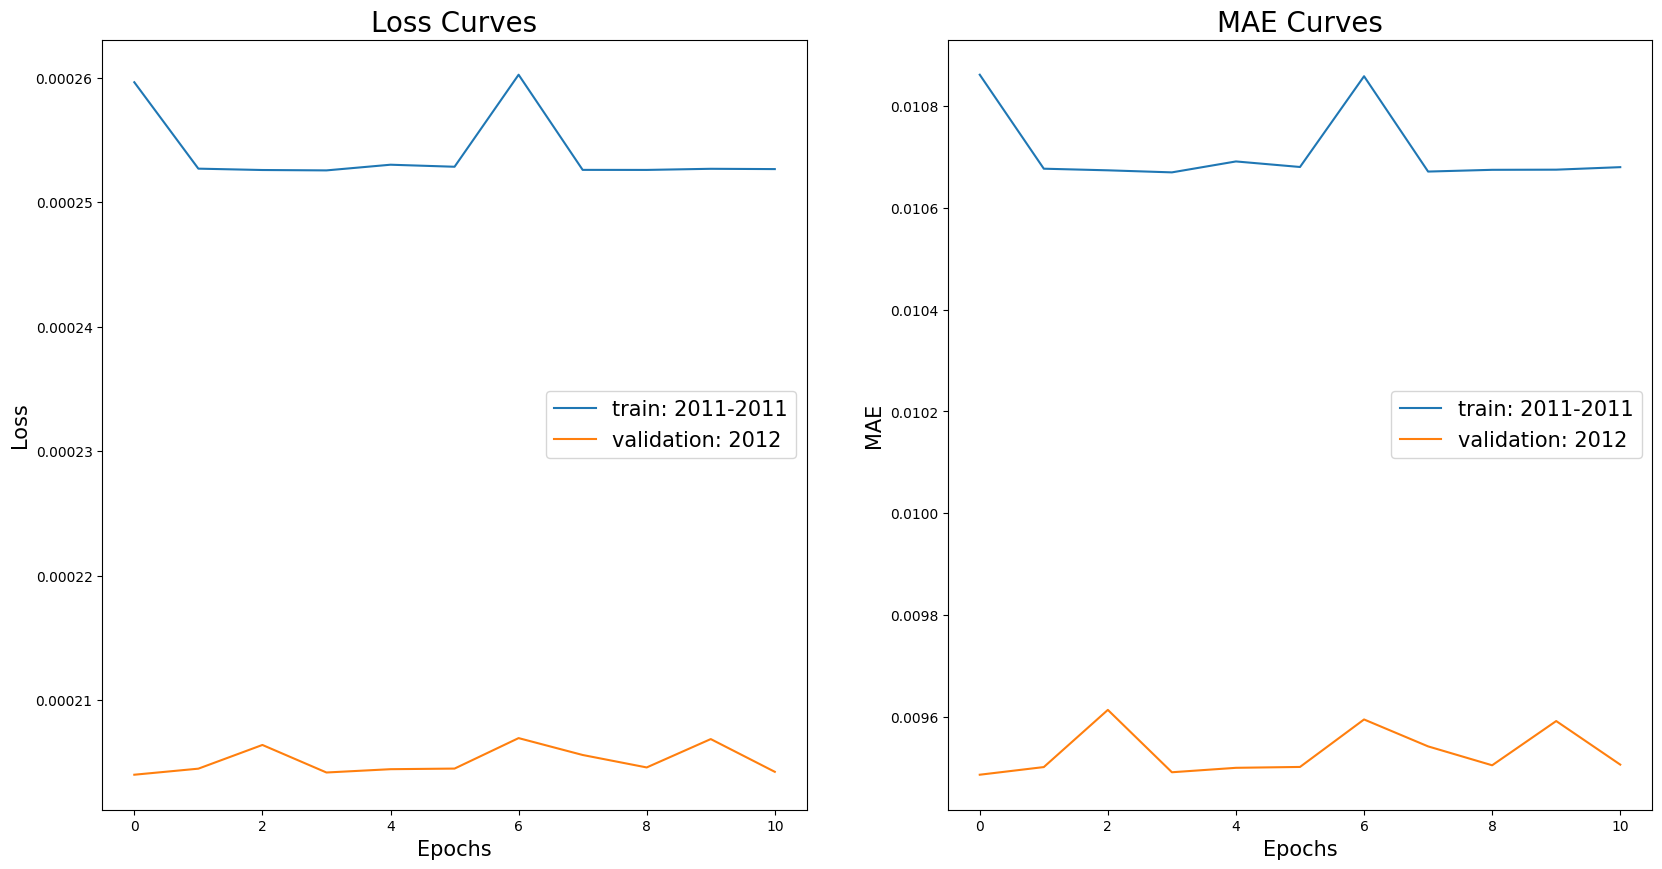

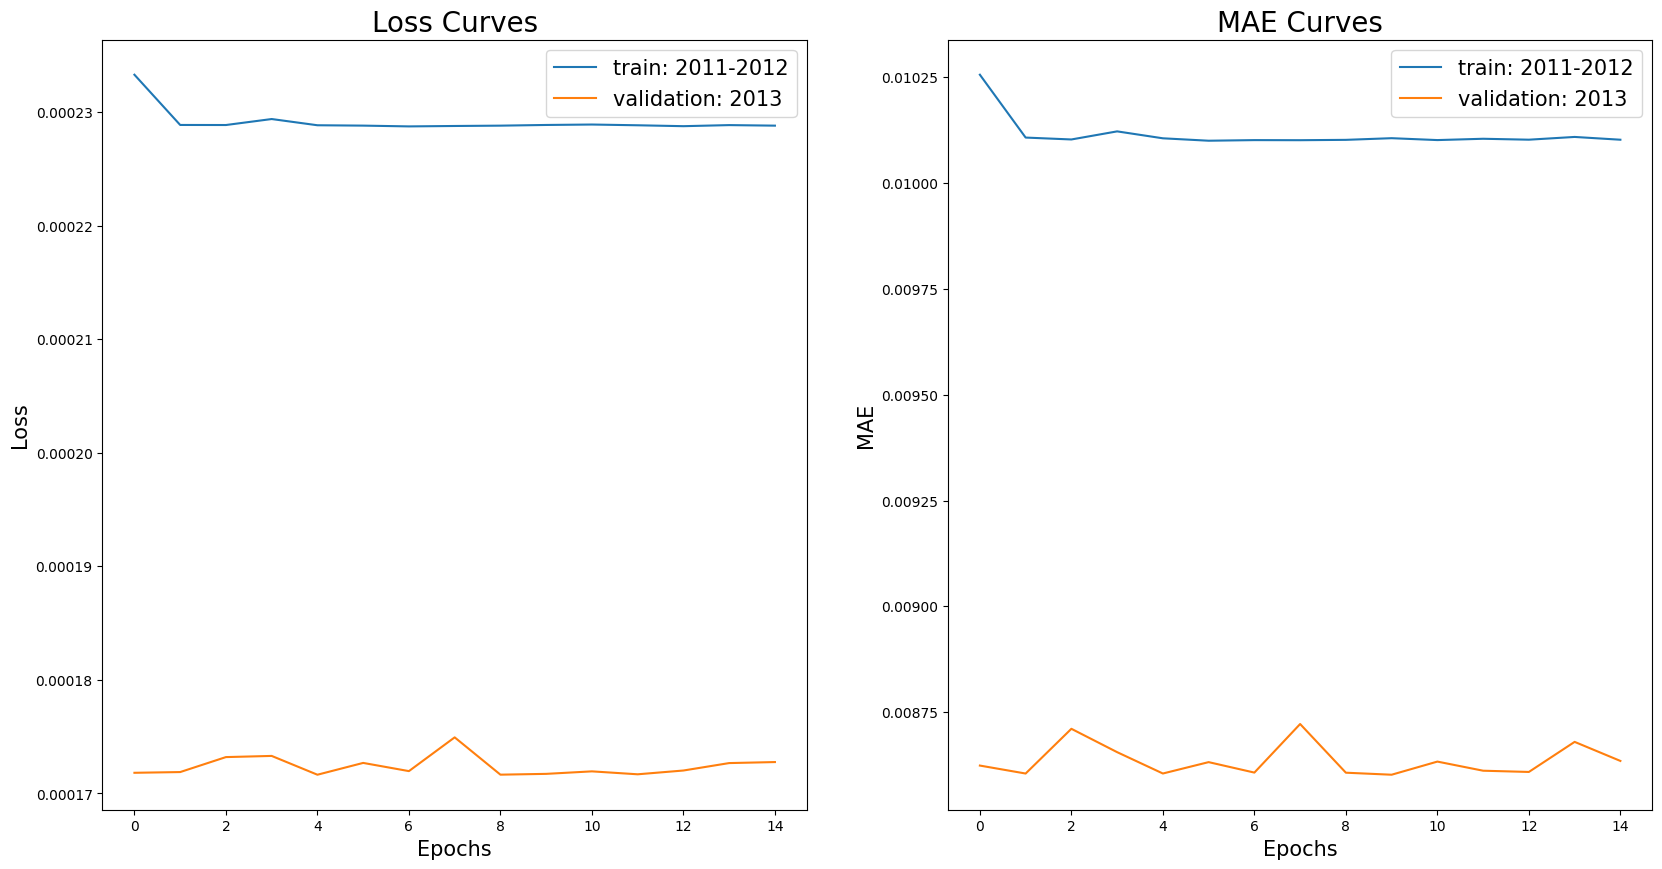

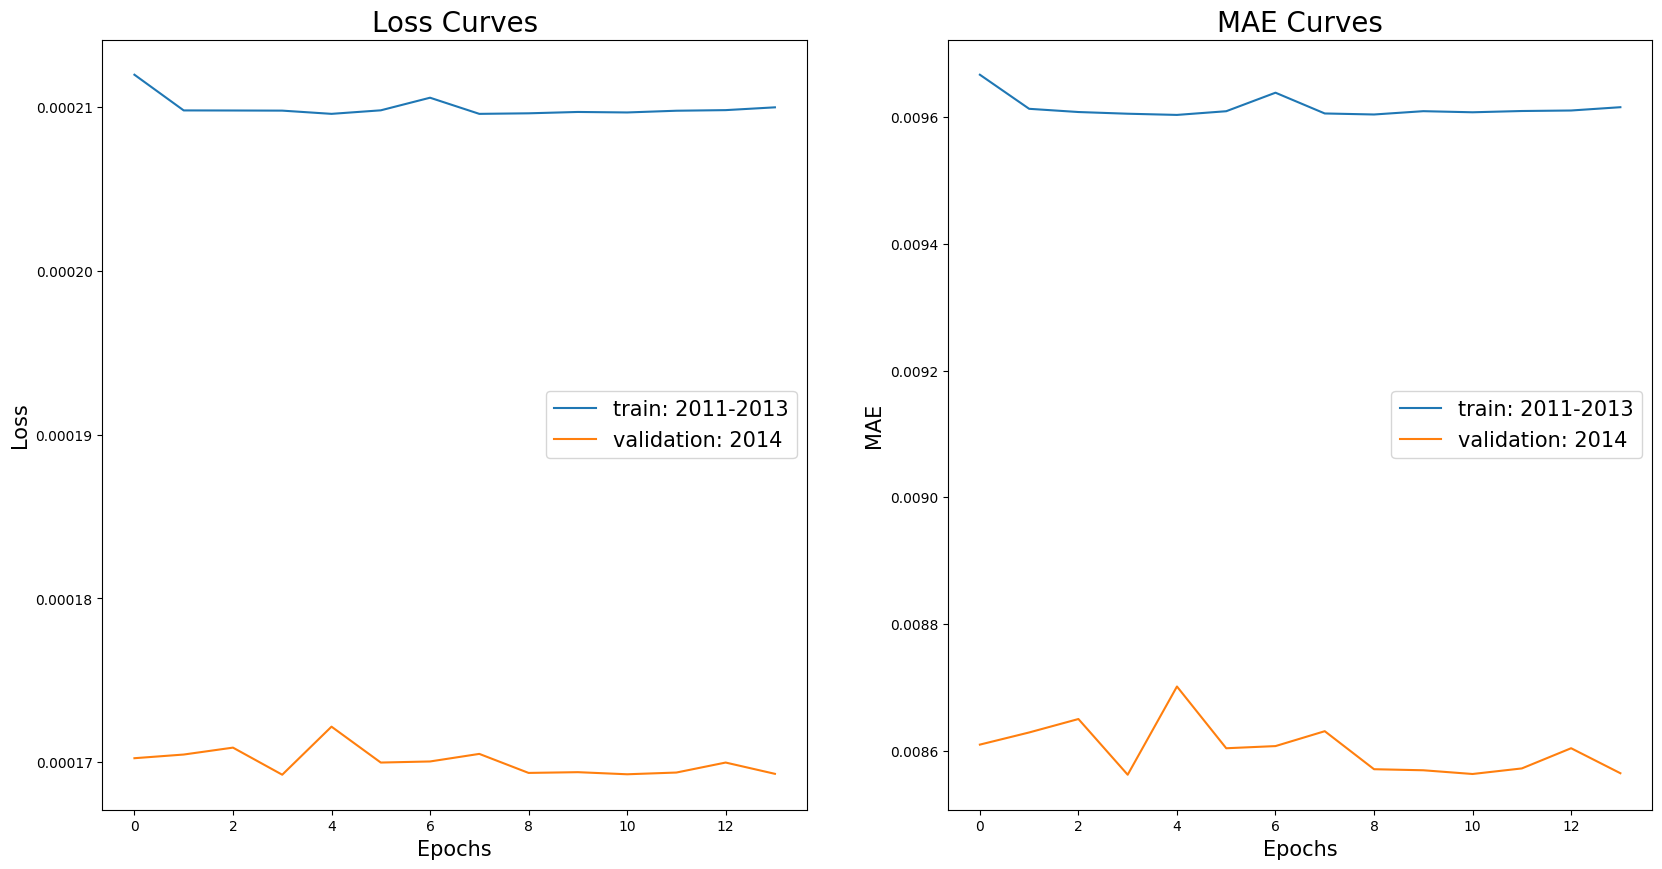

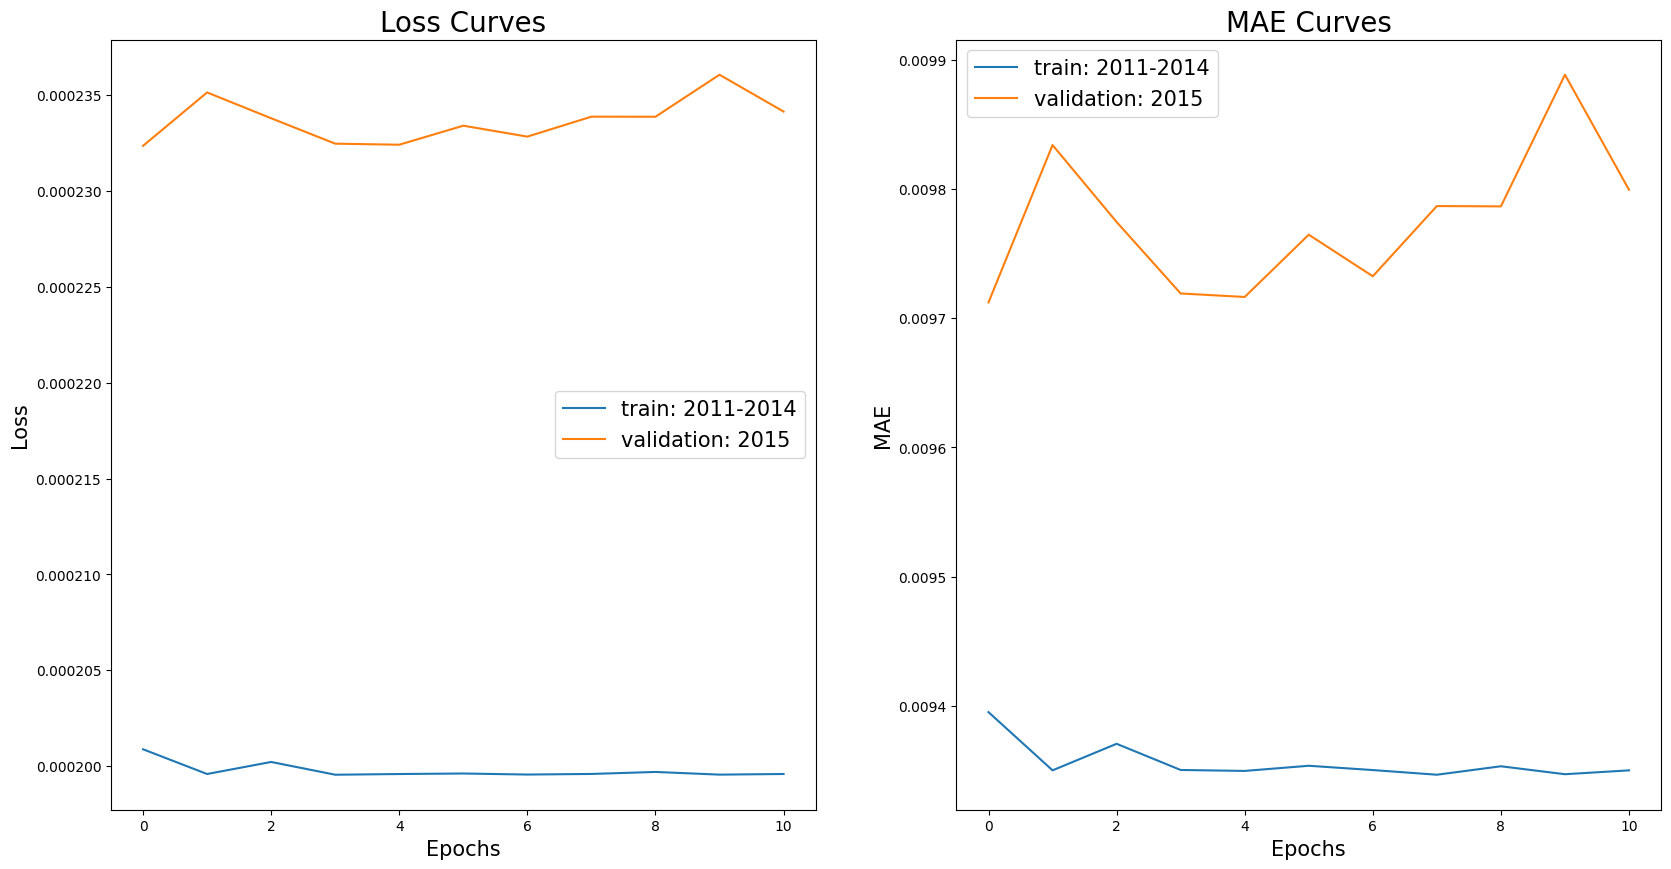

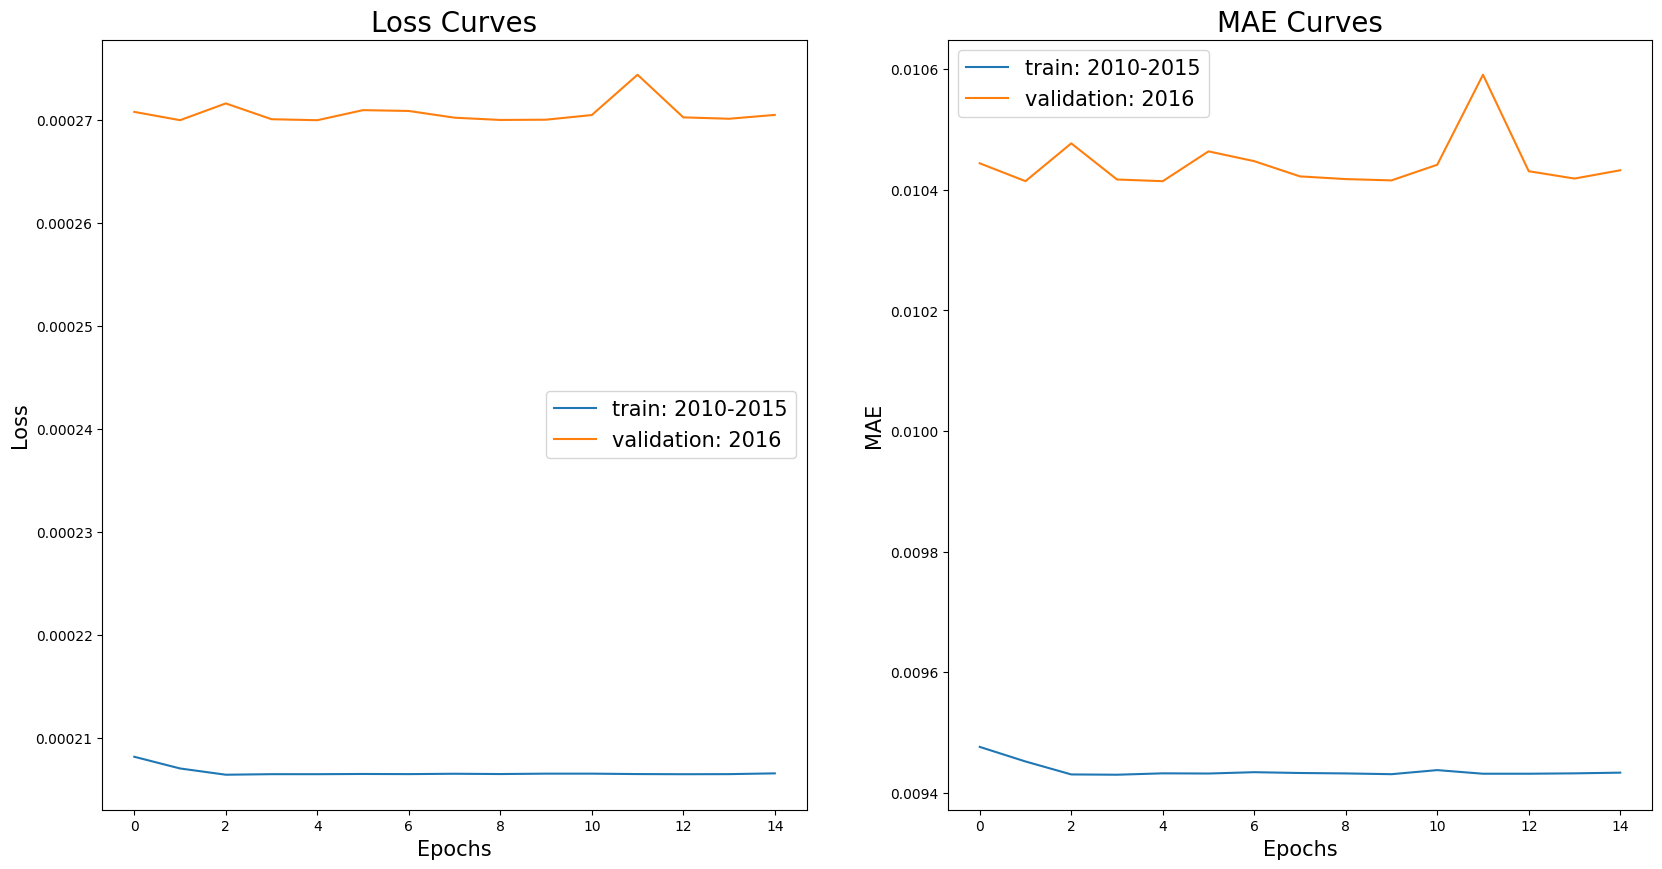

In [20]:
# build models spliting the dataset at different years
start_time = datetime.now()
df_test_all = pd.DataFrame()
for split_years in split_years_list:
    df_test, model = build_model_for_one_fold(df, feature_cols, TARGET_COL, DATE_COL, split_years)
    df_test_all = pd.concat([df_test_all, df_test])
end_time = datetime.now()

In [21]:
print('run time ', end_time-start_time)

run time  1:14:29.551921


In [29]:
df_test_all

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,sector,...,news flag,velocity,novelty,earnings_flag,guidance_flag,merger_flag,rating_flag,z_news,entities_today,y_pred
753,2013-01-02 00:00:00+00:00,82.475458,82.590489,81.286829,81.823631,9617131.0,0.0,0.0,GE,Industrials,...,1,1.0,1.00,0.0,0.0,0.0,0.0,"[0.5582089, -0.51495445, -2.1776328, 0.5764648...",[dow],-0.000213
754,2013-01-03 00:00:00+00:00,82.360452,82.398797,80.711711,80.903427,10122010.0,0.0,0.0,GE,Industrials,...,1,3.0,0.90,0.0,0.0,0.0,1.0,"[0.4739842, -0.992749, 0.17233184, -0.4278955,...","[c, cl, co, cs, ge, merit medical, mind, or, r...",-0.000213
755,2013-01-04 00:00:00+00:00,81.325119,81.516835,80.980033,81.286774,6218673.0,0.0,0.0,GE,Industrials,...,1,1.0,1.00,0.0,0.0,0.0,0.0,"[-1.4885262, 0.3601506, -0.0867607, -0.7952817...",[united technologies],-0.000213
756,2013-01-07 00:00:00+00:00,81.133456,81.363511,80.366598,81.018425,6832995.0,0.0,0.0,GE,Industrials,...,1,1.0,1.00,0.0,0.0,0.0,0.0,"[0.5362583, -1.0512677, -0.79118365, -0.547502...","[ge, genesis]",-0.000213
757,2013-01-08 00:00:00+00:00,80.903347,80.980032,79.292948,80.136490,8355978.0,0.0,0.0,GE,Industrials,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391680,2018-12-20 00:00:00+00:00,18.070000,18.280001,17.459999,17.690001,9096600.0,0.0,0.0,UAA,Consumer Cyclical,...,1,2.0,1.00,0.0,0.0,1.0,0.0,"[0.28532457, -0.67564535, -0.8886598, -0.03112...",[nike],-0.000021
391681,2018-12-21 00:00:00+00:00,17.770000,17.950001,16.850000,16.959999,9401000.0,0.0,0.0,UAA,Consumer Cyclical,...,1,2.0,0.75,1.0,0.0,0.0,0.0,"[0.3655004, -0.40341717, -0.7810211, -0.521143...","[lem, lulu, nike, on]",-0.000021
391682,2018-12-24 00:00:00+00:00,16.740000,17.360001,16.570000,16.750000,2688600.0,0.0,0.0,UAA,Consumer Cyclical,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000021
391683,2018-12-26 00:00:00+00:00,16.790001,17.840000,16.520000,17.820000,3966400.0,0.0,0.0,UAA,Consumer Cyclical,...,1,1.0,0.00,0.0,0.0,0.0,0.0,"[-0.1646266, 0.09255396, -1.3083193, 0.8662855...",[],-0.000021


# Write Files

In [22]:
df_test_all.to_csv('/kaggle/working/price_model_test_predicted.csv')

In [23]:
df_test_all.to_pickle('/kaggle/working/price_model_test_predicted.pkl')

In [24]:
# Save the price model 
model.save("/kaggle/working/price_model.keras")

In [25]:
import kagglehub
handle = "rocklaura/multimodal-eq-sizing_norm"
local_dataset_dir = "/kaggle/working/"
current_datetime = datetime.now().isoformat()
kagglehub.dataset_upload(handle, local_dataset_dir, version_notes=current_datetime)

Uploading Dataset https://www.kaggle.com/datasets/rocklaura/multimodal-eq-sizing_norm ...
More than 50 files detected, creating a zip archive...
Starting upload for file /tmp/tmpa78bfxsn/archive.zip


Uploading: 100%|██████████| 2.11G/2.11G [01:25<00:00, 24.7MB/s]  

Upload successful: /tmp/tmpa78bfxsn/archive.zip (2GB)


Your dataset instance has been created.
Files are being processed...
See at: https://www.kaggle.com/datasets/rocklaura/multimodal-eq-sizing_norm


In [26]:
!rm -rf /kaggle/working/multimodal-eq-sizing